In [2]:
# Imports
import pickle
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import patches
from copy import deepcopy
# import plotly.graph_objects as go
from scipy.optimize import curve_fit
from dataclasses import make_dataclass

import sys
module_path = 'src' 
if module_path not in sys.path:
    sys.path.append(module_path)

# Markus's code
from MM_Plot_Utils import plot, hist
from MM_Maze_Utils import *
from MM_Traj_Utils import *

%matplotlib inline
%reload_ext autoreload
%autoreload 2

# Some lists of nicknames for mice
UnrewNames=['B5','B6','B7','D3','D4','D5','D6','D7','D8','D9']
RewNames=['B1','B2','B3','B4','C1','C3','C6','C7','C8','C9']
AllNames=RewNames+UnrewNames
UnrewNamesSub=['B5','B6','B7','D3','D4','D5','D7','D8','D9'] # excluding D6 which barely entered the maze

rwd_node = 116
frame_rate = 30 # Hz

In [6]:
# List number of bouts for each animal
print('mouse  bouts')
to=0
max_bouts = 0
for nickname in AllNames:
    tf = LoadTraj(nickname+'-tf')
    print(nickname+'     ',len(tf.no))
    
    if len(tf.no) > max_bouts:
        max_bouts = len(tf.no)
        
    to+=len(tf.no)
print('Total  ',to)

mouse  bouts
B1      104
B2      166
B3      147
B4      238
C1      173
C3      339
C6      150
C7      135
C8      164
C9      127
B5      245
B6      223
B7      204
D3      245
D4      319
D5      180
D6      59
D7      150
D8      109
D9      102
Total   3579


B1


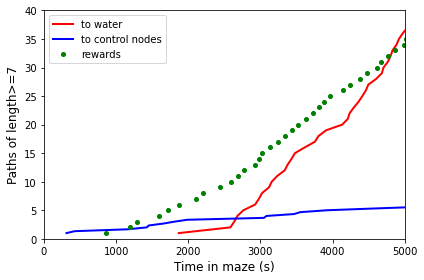

B2


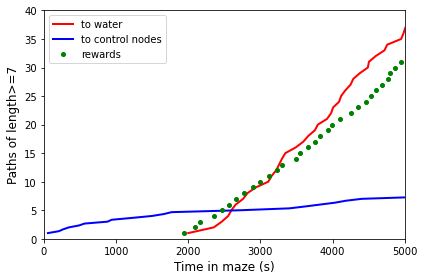

B3


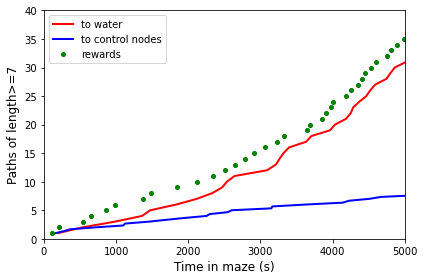

B4


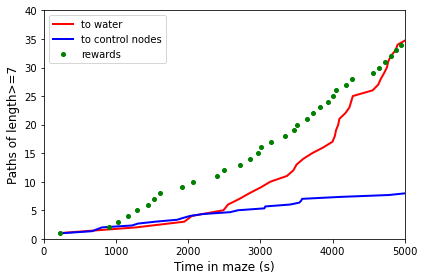

C1


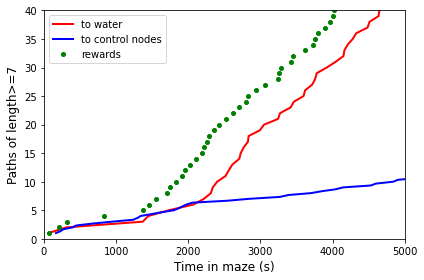

C3


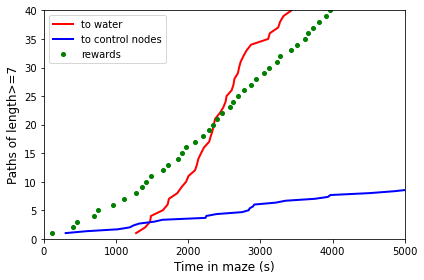

C6


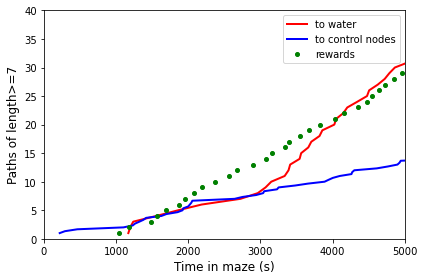

C7


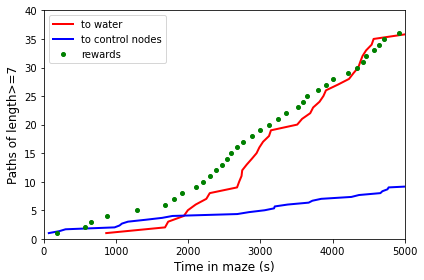

C8


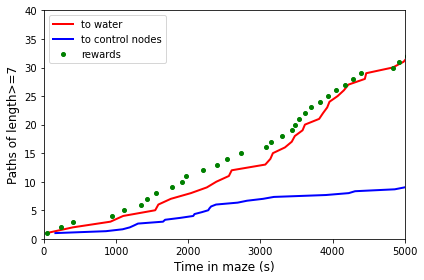

C9


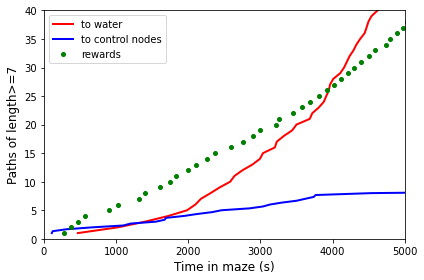

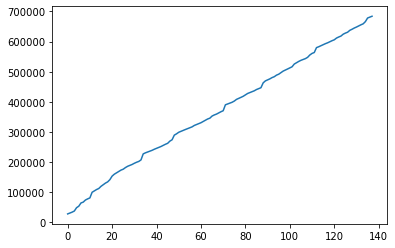

In [9]:
# plot long paths to water & control nodes vs time in maze for all animals, length>=7, time 0-5000 s
for nickname in RewNames:
    tf=LoadTraj(nickname+'-tf')
    # make array of reward times in frames
    re = np.array([y[0]+tf.fr[i,0] for i,r in enumerate(tf.re) for y in r])
    # plot cumulative long paths, rewards, time in maze
    ti=np.array(tf.fr.tolist()) # time in maze
    ptn_1 = FindPathsToNode(116,tf,ma) # water
    ptn_2 = FindPathsToNode(94,tf,ma) # three control nodes
    ptn_3 = FindPathsToNode(95,tf,ma)
    ptn_4 = FindPathsToNode(73,tf,ma)
    lmin=7 # minimal length
    ptn_m = ptn_1[np.where(ptn_1[:,2]>=lmin)] # impose minimal length
    ptn_co_m = np.concatenate((ptn_2,ptn_3,ptn_4)) # combine the 3 control nodes
    ptn_co_m = ptn_co_m[np.where(ptn_co_m[:,2]>=lmin)]
    ptn_co_m = ptn_co_m[np.argsort(ptn_co_m[:,3])]
    x=[TimeInMaze(p,tf) for p in ptn_m[:,3]]
    y=np.arange(len(ptn_m))+1
    ax=plot(x,y,fmts=['r-'],figsize=(6,4)) # cumulative paths to water
    x=[TimeInMaze(p,tf) for p in ptn_co_m[:,3]]
    y=np.arange(len(ptn_co_m))/3+1
    plot(x,y,fmts=['b-'],axes=ax) # avg number of such paths to the control nodes
    x=[TimeInMaze(p,tf) for p in re]
    y=np.arange(len(re))+1
    plot(x,y,fmts=['g.'],markersize=8,axes=ax,
         xlabel='Time in maze (s)',
         ylabel='Paths of length>={}'.format(lmin),
         legend=['to water','to control nodes','rewards'],
         xlim=[0,5000],ylim=[0,40]); # cumulative rewards
    print(nickname)
    plt.show();
plt.plot(re)

# Figure 4A

Check also: https://github.com/markusmeister/Rosenberg-2021-Repository/blob/main/Maze_Analysis_3C.ipynb

C9


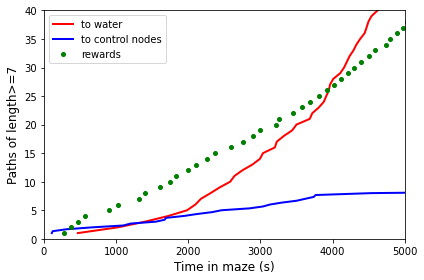

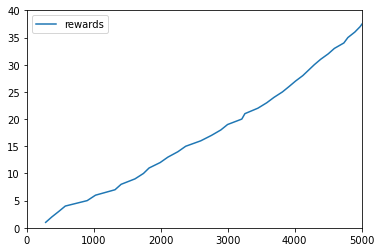

In [12]:
tf=LoadTraj(nickname+'-tf')
# make array of reward times in frames
re = np.array([y[0]+tf.fr[i,0] for i,r in enumerate(tf.re) for y in r])
# plot cumulative long paths, rewards, time in maze
ti=np.array(tf.fr.tolist()) # time in maze
ptn_1 = FindPathsToNode(116,tf,ma) # water
ptn_2 = FindPathsToNode(94,tf,ma) # three control nodes
ptn_3 = FindPathsToNode(95,tf,ma)
ptn_4 = FindPathsToNode(73,tf,ma)
lmin=7 # minimal length
ptn_m = ptn_1[np.where(ptn_1[:,2]>=lmin)] # impose minimal length
ptn_co_m = np.concatenate((ptn_2,ptn_3,ptn_4)) # combine the 3 control nodes
ptn_co_m = ptn_co_m[np.where(ptn_co_m[:,2]>=lmin)]
ptn_co_m = ptn_co_m[np.argsort(ptn_co_m[:,3])]

x=[TimeInMaze(p,tf) for p in ptn_m[:,3]]
y=np.arange(len(ptn_m))+1
ax=plot(x,y,fmts=['r-'],figsize=(6,4)) # cumulative paths to water

x=[TimeInMaze(p,tf) for p in ptn_co_m[:,3]]
y=np.arange(len(ptn_co_m))/3+1
plot(x,y,fmts=['b-'],axes=ax) # avg number of such paths to the control nodes

x=[TimeInMaze(p,tf) for p in re]
y=np.arange(len(re))+1
plot(x,y,fmts=['g.'],markersize=8,axes=ax,
     xlabel='Time in maze (s)',
     ylabel='Paths of length>={}'.format(lmin),
     legend=['to water','to control nodes','rewards'],
     xlim=[0,5000],ylim=[0,40]); # cumulative rewards
print(nickname)
plt.show();


x=[TimeInMaze(p,tf) for p in re]
y=np.arange(len(re))+1
plt.plot(x,y, label='rewards')
plt.xlim(0,5000)
plt.ylim(0,40)
plt.legend()

Plot the cumulative number of paths to water end-node over time. Similar to fig 4B. But, inspired by fig 5B, separate the cumulative counts by the lengths of the paths (1 - just next to the water node -  to 12 - on a leaf node in the north side of the maze).

Why: because it will allow us to analyze if the mouse is changing the kind of paths it takes to water end nodes. Is the animal first taking only small length paths and then, as they learn to navigate the maze, changing the kind of paths they prefer?

Also noteworthy and related: it seems like the animals are indeed taking a reward every 90s after their sudden insight at 1380s in fig 4B. Are they walking to the water end node every 90s, or more often than that?

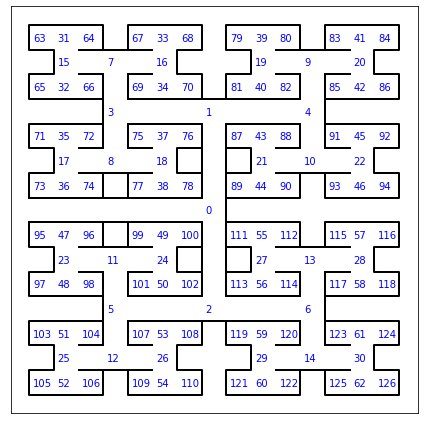

In [3]:
# Draw maze with node numbers
maze=NewMaze(6)
PlotMazeNodes(maze,figsize=6)

In [56]:
maze.xc.shape

(176,)

In [30]:
maze.pa

array([-1,  0,  0,  1,  1,  2,  2,  3,  3,  4,  4,  5,  5,  6,  6,  7,  7,
        8,  8,  9,  9, 10, 10, 11, 11, 12, 12, 13, 13, 14, 14, 15, 15, 16,
       16, 17, 17, 18, 18, 19, 19, 20, 20, 21, 21, 22, 22, 23, 23, 24, 24,
       25, 25, 26, 26, 27, 27, 28, 28, 29, 29, 30, 30, 31, 31, 32, 32, 33,
       33, 34, 34, 35, 35, 36, 36, 37, 37, 38, 38, 39, 39, 40, 40, 41, 41,
       42, 42, 43, 43, 44, 44, 45, 45, 46, 46, 47, 47, 48, 48, 49, 49, 50,
       50, 51, 51, 52, 52, 53, 53, 54, 54, 55, 55, 56, 56, 57, 57, 58, 58,
       59, 59, 60, 60, 61, 61, 62, 62])

In [49]:
maze.rc

array([  0,   0,   0,   0,   0,   0,   0,   0,   1,   1,   1,   1,   2,
         2,   2,   2,   3,   3,   3,   3,   4,   4,   4,   4,   5,   5,
         5,   5,   6,   6,   6,   6,   7,   7,   8,   8,   9,   9,  10,
        10,  11,  11,  12,  12,  13,  13,  14,  14,  15,  15,  16,  16,
        17,  17,  18,  18,  19,  19,  20,  20,  21,  21,  22,  22,  23,
        23,  24,  24,  25,  25,  26,  26,  27,  27,  28,  28,  29,  29,
        30,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,
        42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,
        55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,
        68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,
        81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,
        94,  95,  96,  97,  98,  99, 100, 101, 102, 103, 104, 105, 106,
       107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119,
       120, 121, 122, 123, 124, 125, 126])

In [32]:
maze.rc[165], maze.rc[106]

(116, 57)

In [33]:
maze.di[165,106]

1

(176, 176)

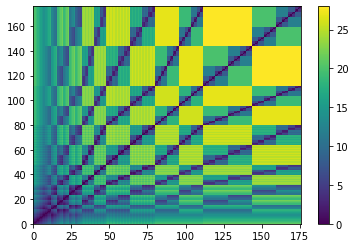

In [4]:
pcolor(maze.di)
colorbar()
maze.di.shape

In [26]:
[r for r in maze.ru]

[[0, 1, 2, 3, 4, 5, 6, 7],
 [8, 9, 10, 11],
 [12, 13, 14, 15],
 [16, 17, 18, 19],
 [20, 21, 22, 23],
 [24, 25, 26, 27],
 [28, 29, 30, 31],
 [32, 33],
 [34, 35],
 [36, 37],
 [38, 39],
 [40, 41],
 [42, 43],
 [44, 45],
 [46, 47],
 [48, 49],
 [50, 51],
 [52, 53],
 [54, 55],
 [56, 57],
 [58, 59],
 [60, 61],
 [62, 63],
 [64, 65],
 [66, 67],
 [68, 69],
 [70, 71],
 [72, 73],
 [74, 75],
 [76, 77],
 [78, 79],
 [80],
 [81],
 [82],
 [83],
 [84],
 [85],
 [86],
 [87],
 [88],
 [89],
 [90],
 [91],
 [92],
 [93],
 [94],
 [95],
 [96],
 [97],
 [98],
 [99],
 [100],
 [101],
 [102],
 [103],
 [104],
 [105],
 [106],
 [107],
 [108],
 [109],
 [110],
 [111],
 [112],
 [113],
 [114],
 [115],
 [116],
 [117],
 [118],
 [119],
 [120],
 [121],
 [122],
 [123],
 [124],
 [125],
 [126],
 [127],
 [128],
 [129],
 [130],
 [131],
 [132],
 [133],
 [134],
 [135],
 [136],
 [137],
 [138],
 [139],
 [140],
 [141],
 [142],
 [143],
 [144],
 [145],
 [146],
 [147],
 [148],
 [149],
 [150],
 [151],
 [152],
 [153],
 [154],
 [155],
 [156],
 

(0.0, 20.0)

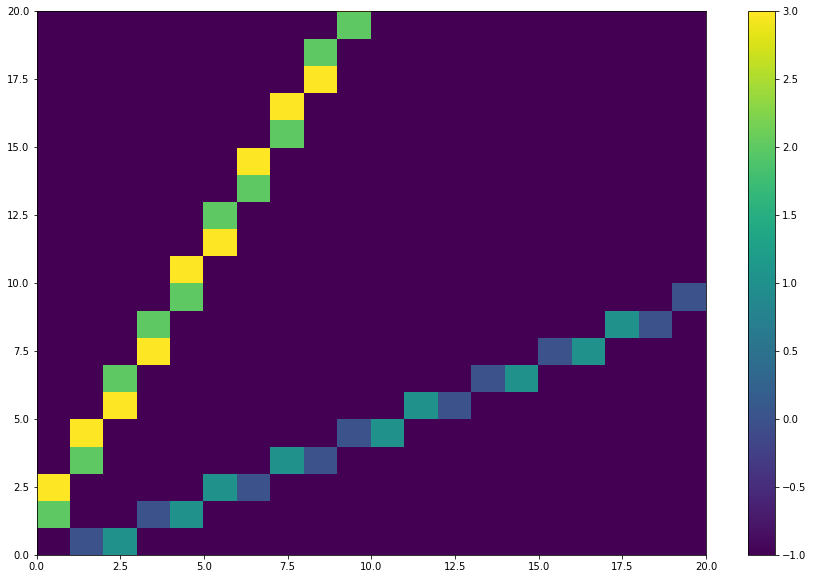

In [41]:
figure(figsize=(15,10))
pcolor(maze.st)
colorbar()
xlim(0,20)
ylim(0,20)

Dark blue is invalid move. Other colors seem to be different types of moves.

In [79]:
nickname = "B3"
tf=LoadTraj(nickname+'-tf')
FindPathsToNode(rwd_node,tf,maze).shape

(81, 4)

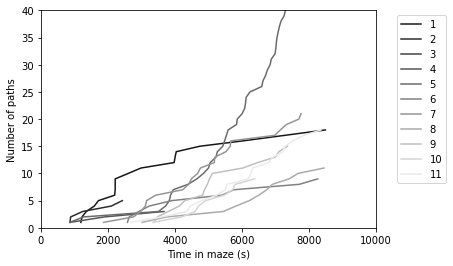

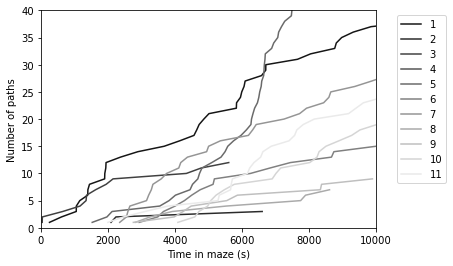

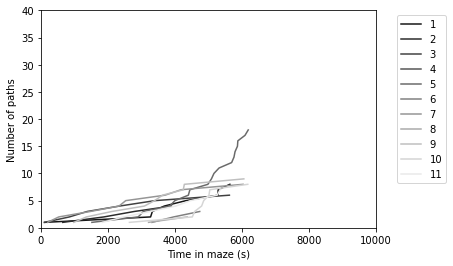

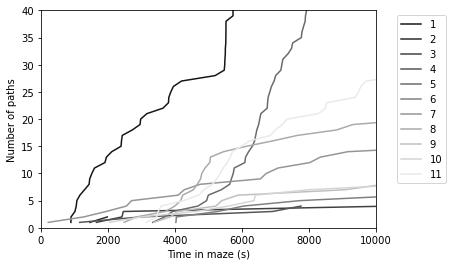

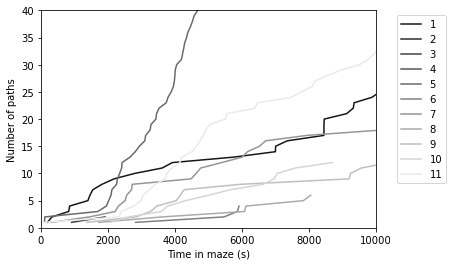

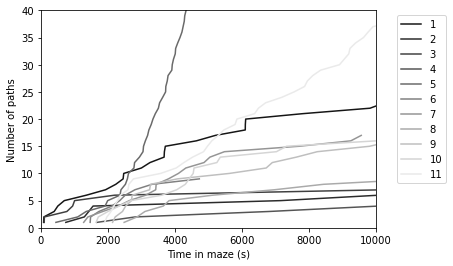

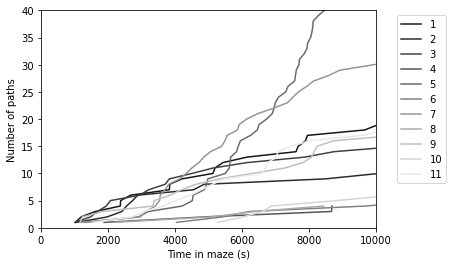

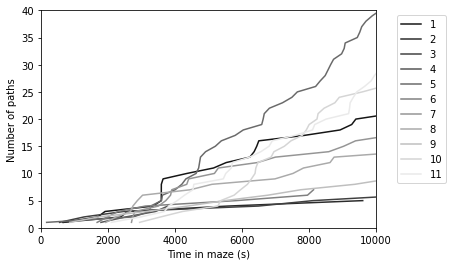

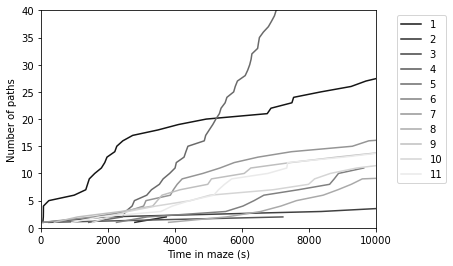

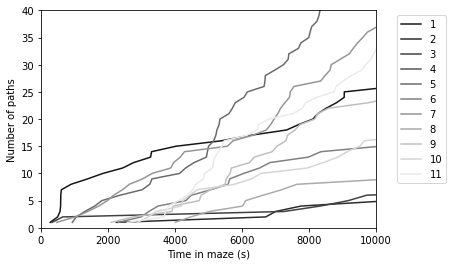

In [104]:
nickname = "C1"

for nickname in RewNames:
    tf=LoadTraj(nickname+'-tf')

    # plot cumulative long paths, rewards, time in maze
    ti=np.array(tf.fr.tolist()) # time in maze
    path_to_water = FindPathsToNode(rwd_node,tf,maze) # water
    ptn_2 = FindPathsToNode(94,tf,maze) # three control nodes
    ptn_3 = FindPathsToNode(95,tf,maze)
    ptn_4 = FindPathsToNode(73,tf,maze)

    paths_to_water = []
    for i in range(1, 13):
        paths_to_water.append(path_to_water[np.where(path_to_water[:,2]==i)])

#     ptn_co_m = np.concatenate((ptn_2,ptn_3,ptn_4)) # combine the 3 control nodes
#     ptn_co_m = ptn_co_m[np.where(ptn_co_m[:,2]>=lmin)]
#     ptn_co_m = ptn_co_m[np.argsort(ptn_co_m[:,3])]

    plt.figure()
    for i in range(1, 12):
    #     print(i)
        x=[TimeInMaze(p,tf) for p in paths_to_water[i][:,3]]
        y=np.arange(len(paths_to_water[i]))+1
        plt.plot(x,y, label=i, color=str(i/12)) # cumulative paths to water
        plt.xlabel('Time in maze (s)')
        plt.ylabel('Number of paths')

#     x=[TimeInMaze(p,tf) for p in ptn_co_m[:,3]]
#     y=np.arange(len(ptn_co_m))/3+1
#     plt.plot(x,y, label='to control nodes') # avg number of such paths to the control nodes
#     plt.xlabel('Time in maze (s)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.xlim(0,10000)
    plt.ylim(0,40);